<a href="https://colab.research.google.com/github/wooysj/ProgrammingAssignment2/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
y_train == 0

array([False,  True, False, ..., False, False, False])

In [5]:
testing = X_train[y_train == 0]

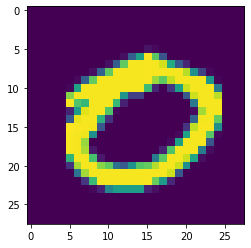

In [6]:
plt.imshow(testing[14])

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential

In [9]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
codings_size = 100

generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape([28, 28]))

In [11]:
GAN = Sequential([generator, discriminator])

In [12]:
discriminator.traininable = False

In [13]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
my_data = testing

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [17]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [19]:
batch_size = 32
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [20]:
epochs = 1

In [21]:
GAN.layers

In [22]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
  print(f"currently on epoch {epoch+1}")
  i = 0

  for X_batch in dataset:
    i = i + 1
    if i % 100  == 0:
      print(f"\t Currently on batch number {i} of {len(my_data) // batch_size}")

    # discriminator training phase

    noise = tf.random.normal(shape=[batch_size, codings_size])
    gen_images = generator(noise)

    X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)

    # corresponds to the fake vs real_images
    y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
    discriminator.trainable = True

    discriminator.train_on_batch(X_fake_vs_real, y1)

    # train generator

    noise = tf.random.normal(shape=[batch_size, codings_size])
    y2 = tf.constant([[1.0]] * batch_size)
    discriminator.trainable = False

    GAN.train_on_batch(noise, y2)

currently on epoch 1
	 Currently on batch number 100 of 185


In [23]:
noise = tf.random.normal(shape=[10, codings_size])

In [24]:
noise.shape

TensorShape([10, 100])

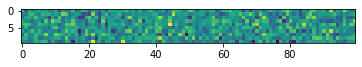

In [25]:
plt.imshow(noise)

In [26]:
images = generator(noise)

In [27]:
images.shape

TensorShape([10, 28, 28])

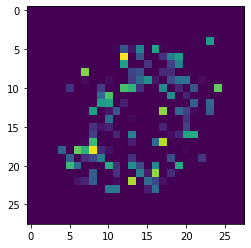

In [29]:
plt.imshow(images[0])

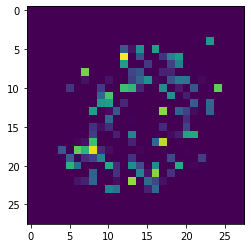

In [30]:
plt.imshow(images[1])

In [31]:
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [33]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [34]:
dataset = dataset.dropna()

In [35]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [36]:
dataset = pd.get_dummies(dataset, columns = ['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [37]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

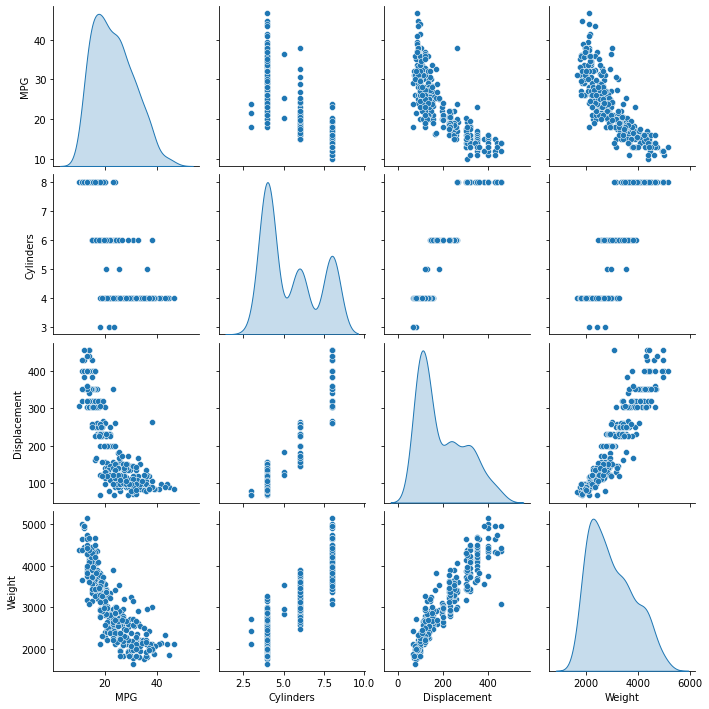

In [38]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [39]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [40]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [41]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [42]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [43]:
horsepower_model = tf.keras.Sequential([horsepower_normalizer, layers.Dense(units=1)])
horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [44]:
horsepower_model.predict(horsepower[:10])

array([[ 0.23950854],
       [ 0.13526787],
       [-0.44206506],
       [ 0.3357307 ],
       [ 0.30365664],
       [ 0.11923084],
       [ 0.35978624],
       [ 0.30365664],
       [ 0.07913828],
       [ 0.13526787]], dtype=float32)

In [45]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [46]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: user 5.69 s, sys: 189 ms, total: 5.88 s
Wall time: 10.8 s


In [47]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807146,4.205587,95
96,3.805156,4.181111,96
97,3.803895,4.196691,97
98,3.803135,4.189139,98
99,3.802603,4.185551,99


In [48]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

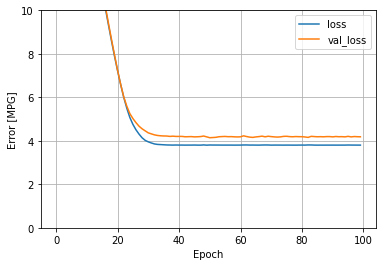

In [49]:
plot_loss(history)

In [50]:
def build_and_compile_model(norm):
  model = keras.Sequential([norm, 
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [51]:
dnn_hp_model = build_and_compile_model(horsepower_normalizer)

In [52]:
dnn_hp_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                128       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [53]:
%%time
history = dnn_hp_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.19 s, sys: 216 ms, total: 6.41 s
Wall time: 7.24 s


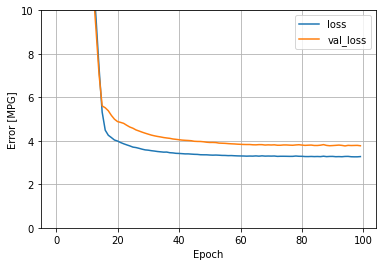

In [54]:
plot_loss(history)